In [2]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import Parameter

In [ ]:
service = QiskitRuntimeService.save_account(token, instance="*", overwrite="True")

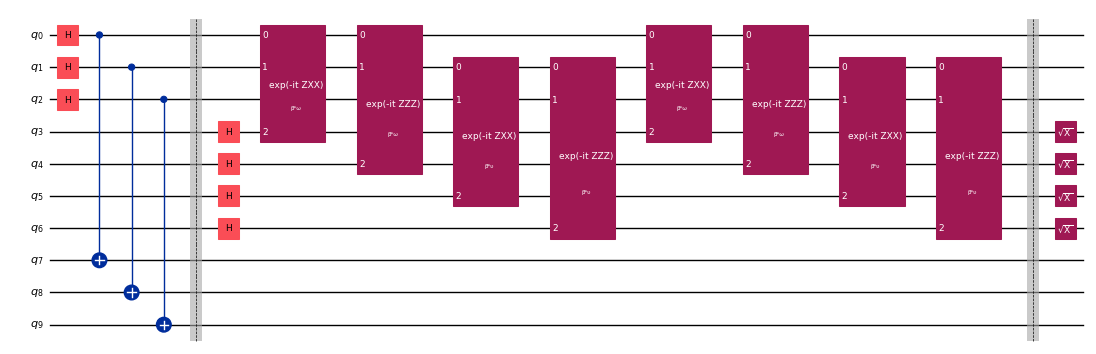

In [6]:
ω = Parameter('ω')
ν = Parameter('υ')
β = Parameter('β')

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")

qc_sym = QuantumCircuit(10)

qc_sym.h([0,1,2])
qc_sym.cx(0,7)
qc_sym.cx(1,8)
qc_sym.cx(2,9)
qc_sym.barrier()

ZXXω = PauliEvolutionGate(Z^X^X, time=β*ω)
ZZZω = PauliEvolutionGate(Z^Z^Z, time=β*ω)

ZXXν = PauliEvolutionGate(Z^X^X, time=β*ν)
ZZZν = PauliEvolutionGate(Z^Z^Z, time=β*ν)

qc_sym.h([3,4,5,6])

qc_sym.append(ZXXω,[0,1,3])
qc_sym.append(ZZZω,[0,1,4])

qc_sym.append(ZXXν,[1,2,5])
qc_sym.append(ZZZν,[1,2,6])

qc_sym.append(ZXXω,[0,1,3])
qc_sym.append(ZZZω,[0,1,4])

qc_sym.append(ZXXν,[1,2,5])
qc_sym.append(ZZZν,[1,2,6])

qc_sym.barrier()

qc_sym.sx([3,4,5,6])

qc_sym.draw("mpl",scale=0.5,fold=1000)

In [8]:
sim = AerSimulator(method="statevector")

In [10]:
H_sym = SparsePauliOp(["IIIIIZIIZZ","IIIIIIZIXX","IIIZIIIZZI","IIIIZIIXXI"], coeffs=[ω,ω,ν,ν])

In [14]:
H_fix = H_sym.assign_parameters({ω:pi/4,ν:pi/4})
H_fix = SparsePauliOp(H_fix.paulis, coeffs=np.asarray(H_fix.coeffs, dtype=np.complex128)) #Forcing correct assignment

In [16]:
pm = generate_preset_pass_manager(backend=sim, optimization_level=3)

In [18]:
vals = np.linspace(0.0, 0.4, 11)

In [20]:
results = [] 
for val in vals:
    qc = qc_sym.assign_parameters({ω:pi/4,ν:pi/4,β: -val})
    isa_qc = pm.run(qc)                 
    isa_H = H_fix.apply_layout(isa_qc.layout)
    results.append({"beta": val, "isa_qc": isa_qc, "isa_H": isa_H})

In [22]:
estimator = Estimator(mode=sim, options={"default_shots": 10000})

In [24]:
trotter_steps = 2

In [52]:
approx = []
for item in results:
    beta = item["beta"]
    isa_qc = item["isa_qc"]
    isa_H = item["isa_H"]

    res = estimator.run([(isa_qc, isa_H)]).result()[0]
    ev = res.data.evs
    approx.append((beta*2*trotter_steps, ev))
    print(f"β = {beta*2*trotter_steps:.3f}, Expectation value = {ev}")

β = 0.000, Expectation value = -0.024347343065320895
β = 0.160, Expectation value = -0.3696083756948392
β = 0.320, Expectation value = -0.7819424114784994
β = 0.480, Expectation value = -1.1254755681485435
β = 0.640, Expectation value = -1.4515728855911638
β = 0.800, Expectation value = -1.707298527593373
β = 0.960, Expectation value = -1.912601607505466
β = 1.120, Expectation value = -2.0770639829208917
β = 1.280, Expectation value = -2.148692295422739
β = 1.440, Expectation value = -2.181993177550791
β = 1.600, Expectation value = -2.1309422969299567


In [54]:
omega = pi/4
vi = pi/4

I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1],[1, 0]])
Z = np.array([[1, 0],[0,-1]])

ZZI = np.kron(np.kron(Z, Z), I)  
XXI = np.kron(np.kron(X, X), I) 
IZZ = np.kron(np.kron(I, Z), Z) 
IXX = np.kron(np.kron(I, X), X) 
H = omega * (ZZI + XXI) + vi * (IZZ + IXX)

eps, V = np.linalg.eigh(H)

def thermal_average_H(beta: float) -> float:

    w = np.exp(-beta * eps)
    Z = np.sum(w)
    return float(np.sum(eps * w) / Z)

beta_values = np.linspace(0., 1.6, 11)

thermal_averages = np.array([thermal_average_H(b) for b in beta_values])

for b, e in zip(beta_values, thermal_averages):
    print(f"beta = {b:.3f} -> <H>_beta = {e:.10f}")

beta = 0.000 -> <H>_beta = 0.0000000000
beta = 0.160 -> <H>_beta = -0.3906798968
beta = 0.320 -> <H>_beta = -0.7579178030
beta = 0.480 -> <H>_beta = -1.0835796041
beta = 0.640 -> <H>_beta = -1.3577819656
beta = 0.800 -> <H>_beta = -1.5787561695
beta = 0.960 -> <H>_beta = -1.7506293804
beta = 1.120 -> <H>_beta = -1.8806603742
beta = 1.280 -> <H>_beta = -1.9769889846
beta = 1.440 -> <H>_beta = -2.0472446770
beta = 1.600 -> <H>_beta = -2.0979030027


In [34]:
def exp_func(beta, a, b, c):
    return a * np.exp(-b * beta) + c

In [36]:
gs = np.min(np.linalg.eigvalsh(H))

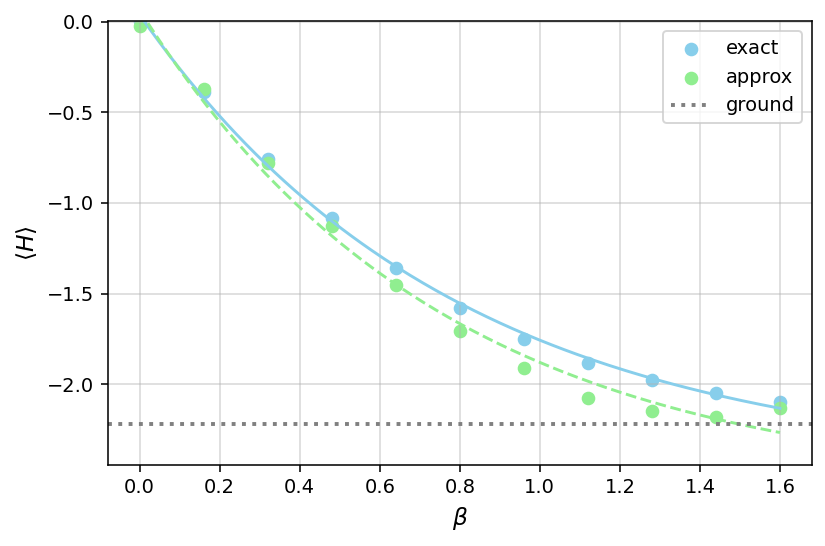

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

betas_circ, evs_circ = zip(*approx)

def exp_func(beta, a, b, c):
    return a * np.exp(-b * beta) + c

params_th, _ = curve_fit(exp_func, beta_values, thermal_averages, p0=(1,1,0))
params_circ, _ = curve_fit(exp_func, betas_circ, evs_circ, p0=(1,1,0))

beta_smooth = np.linspace(min(beta_values), max(beta_values), 200)
thermal_fit = exp_func(beta_smooth, *params_th)
circuit_fit = exp_func(beta_smooth, *params_circ)

plt.figure(figsize=(6,4),dpi=140)

plt.scatter(beta_values, thermal_averages, color='skyblue', label='exact')
plt.scatter(betas_circ, evs_circ, color='lightgreen', label='approx')

plt.plot(beta_smooth, thermal_fit, color='skyblue', linestyle='-')
plt.plot(beta_smooth, circuit_fit, color='lightgreen', linestyle='--')

plt.axhline(y=gs, color='gray', linestyle=':', linewidth=2, label='ground')

ymin = min(np.min(thermal_averages), np.min(evs_circ), gs)
ymax = max(np.max(thermal_averages), np.max(evs_circ))
plt.ylim(ymin - 0.1 * abs(ymin), ymax)

plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'$\langle H \rangle $', fontsize=12)
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()